In [1]:
import pickle
processed_data = pickle.load(open("../../../fever_processed.pickle", "rb"))

### Data prep for Evidence Accumulation

* The significance of a given statement as evidence to a claim/question is modelled as a classification problem
* A class is awarded to potential evidence based on the following:
    - Class 0, if the evidence tokens do not contribute to answering the question
    - Class 1, if the evidence tokens partially or fully answer the question
* The evidence and the claim are put through the same bert instance, but are put through separately. 

In [2]:
max_len_claims = 30
max_len_evid = 90

In [3]:
lines = []
classes = []
import numpy as np
from pytorch_pretrained_bert import BertTokenizer
import json
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def make_data(claim, evidence):
    _fctokens = ["[CLS]"]
    _fctokens.extend(claim)
    _fetokens = ["[CLS]"]
    _fetokens.extend(evidence) 
    while len(_fctokens) < max_len_claims:
        _fctokens.append("[PAD]")
    while len(_fetokens) < max_len_evid:
        _fetokens.append("[PAD]")
    _fctokens = _fctokens[:max_len_claims]
    _fetokens = _fetokens[:max_len_evid]
    _csegments = np.zeros((max_len_claims,))
    _esegments = np.zeros((max_len_evid,))
    ctokens = tokenizer.convert_tokens_to_ids(_fctokens)
    etokens = tokenizer.convert_tokens_to_ids(_fetokens)
    return (ctokens, etokens, _esegments)

counter = 0
for line in processed_data:
    counter += 1
    print(counter, "/", len(processed_data), end="\r")
    for evidence in line["processed"]["evidentiary"]:
        lines.append(make_data(line["processed"]["claim"], evidence))
        if (len(line["processed"]["evidentiary"]) >= 1):
            classes.append(1)
    for evidence in line["processed"]["non_evidentiary"]:
        lines.append(make_data(line["processed"]["claim"], evidence))
        classes.append(0)


In [4]:
print("Total data points = ", len(classes))
print("Of which evidentiary:", np.count_nonzero(classes))

training_lines = lines[:-len(classes)//10]
training_classes = classes[:-len(classes)//10]

print("Total training data points = ", len(training_classes))
print("Of which evidentiary:", np.count_nonzero(training_classes))

training_evidentiary_indices = [i for i in range(len(training_classes)) if training_classes[i] > 0 ]
training_nonevidentiary_indices = [i for i in range(len(training_classes)) if training_classes[i] == 0]

testing_lines = lines[-len(classes)//10:]
testing_classes = classes[-len(classes)//10:]

testing_evidentiary_indices = [i for i in range(len(testing_classes)) if testing_classes[i] > 0 ]
testing_nonevidentiary_indices = [i for i in range(len(testing_classes)) if testing_classes[i] == 0]

print("Total testing data points = ", len(testing_classes))
print("Of which evidentiary:", np.count_nonzero(testing_classes))


Total data points =  1605875
Of which evidentiary: 201060
Total training data points =  1445287
Of which evidentiary: 180997
Total testing data points =  160588
Of which evidentiary: 20063


### Relevant Fact Extraction (ReFE)

* Each sequence (claim/question and evidence) are put through bert separately. 
* The output of both is passed through a biDAF layer. 
* The claim and the output of bidaf are further passed through inner attention layers
* The outputs of the inner attention are concatenated and passed through a perceptron. 

In [6]:
import torch
import torch.nn.functional as F
from pytorch_pretrained_bert import BertModel

In [ ]:
train_fp16 = False
if (train_fp16):
    from apex import amp
    from apex.fp16_utils import FP16_Optimizer

In [7]:
lossFn = torch.nn.BCEWithLogitsLoss()
def getLoss(pred, actual, lossFn, e_weight=0.6, ne_weight=0.4):
    loss = lossFn(pred.squeeze(-1), actual)
    return loss

In [ ]:
epoch_losses = []
epoch_vals = []
epoch_accs = []
epoch_evid = []

In [ ]:
def getTrainingBatch(bs = 64, validation = False):
    
    evidentiary = training_evidentiary_indices
    non_evidentiary = training_nonevidentiary_indices
    source = training_lines
    source_classes = training_classes
    
    if (validation):
        evidentiary = testing_evidentiary_indices
        non_evidentiary = testing_nonevidentiary_indices
        source = testing_lines
        source_classes = testing_classes
        
    ev_total = bs // 2
    nev_total = bs - ev_total
    x = np.random.randint(0, len(evidentiary), (ev_total))
    x = np.asarray(evidentiary)[x]
    _base_ctokens = [source[index][0] for index in x]
    _base_etokens = [source[index][1] for index in x]

    _classes = [source_classes[index] for index in x]
    
    x = np.random.randint(0, len(non_evidentiary), (nev_total))
    x = np.asarray(non_evidentiary)[x]
    _base_ctokens_ne = [source[index][0] for index in x]
    _base_etokens_ne = [source[index][1] for index in x]
    _classes_ne = [source_classes[index] for index in x]
    
    _base_ctokens.extend(_base_ctokens_ne)
    _base_etokens.extend(_base_etokens_ne)
    _classes.extend(_classes_ne)
        
    final_seq = [i for i in range(bs)]
    np.random.shuffle(final_seq)
    
    ctokens = []
    etokens = []
    csegments = np.zeros((bs, max_len_claims))
    esegments = np.zeros((bs, max_len_evid))
    classes = []
    for index in final_seq:
        ctokens.append(_base_ctokens[index])
        etokens.append(_base_etokens[index])
        classes.append(_classes[index])
    
    ctokens = torch.LongTensor(ctokens).cuda()
    csegments = torch.LongTensor(csegments).cuda()
    etokens = torch.LongTensor(etokens).cuda()
    esegments = torch.LongTensor(esegments).cuda()
    classes = torch.FloatTensor(classes).cuda()
    catt_mask = ctokens != 0
    eatt_mask = etokens != 0
    
    return ctokens, csegments, catt_mask, etokens, esegments, eatt_mask, classes
    
ctokens, csegments, catt_mask, etokens, esegments, eatt_mask, classes = getTrainingBatch()

In [ ]:
print(ctokens.size(), csegments.size(), catt_mask.size())
print(etokens.size(), esegments.size(), eatt_mask.size())

In [13]:
import torch
from QA_Attentions import *

class ReFE(torch.nn.Module):
    def __init__(self, bert_model = "bert-base-uncased"):
        super(ReFE, self).__init__()
        self.bert_model = bert_model
        self.bert_width = 768
        if ("-large-" in self.bert_model):
            self.bert_width = 1024
        self.bert = BertModel.from_pretrained(bert_model)
        self.wd = torch.nn.Parameter(torch.FloatTensor(np.random.uniform(0, 1, (3*self.bert_width,))))
        self.innerAttQuery = torch.nn.Parameter(torch.FloatTensor(np.random.uniform(0, 1, (self.bert_width, 512))))
        self.innerAttDoc = torch.nn.Parameter(torch.FloatTensor(np.random.uniform(0, 1, (self.bert_width*4, 512))))
        self.out = torch.nn.Linear((self.bert_width*4),1)
        self.dropout = torch.nn.Dropout(0.1)
    
    def forward(self, dt, ds, da, qt, qs, qa):
        queries, pooled = self.bert(qt, 
                         token_type_ids=qs, 
                         attention_mask=qa, 
                         output_all_encoded_layers=False)
        
        documents, pooled = self.bert(dt, 
                         token_type_ids=ds, 
                         attention_mask=da, 
                         output_all_encoded_layers=False)
        
        if (train_fp16):
            queries = self.dropout(queries * qa.unsqueeze(-1).half().cuda())
            documents = self.dropout(documents * da.unsqueeze(-1).half().cuda())
        else:
            queries = self.dropout(queries * qa.unsqueeze(-1).float())
            documents = self.dropout(documents * da.unsqueeze(-1).float())
        
        bdaf, ad2q, aq2d = biDAF(documents, queries, self.wd)
        #q = InnerAttention(queries, self.innerAttQuery)
        d = InnerAttention(bdaf, self.innerAttDoc)
        #_f = torch.cat([q,d],dim=-1)
        out_ = self.out(d)
        return out_

In [ ]:
continue_from_prev = False

In [ ]:
import json
network = None
if (continue_from_prev):
    network = torch.load("./ReFE_BestValidationLoss_save.h5")
    tcycle = None
    with open("./saved_model_training_cycle.json", "r") as f:
        tcycle = json.loads(f.read())
    epoch_losses = tcycle["training_losses"][:-2]
    epoch_vals = tcycle["validation_losses"][:-2]
    epoch_accs = tcycle["validation_accuracy"][:-2]
    epoch_evid = tcycle["evidence_accuracy"][:-2]
else:
    network = ReFE()

In [ ]:
lr = 3e-5
"""
if (train_fp16):
    lr = 3e-4
"""
optimizer = torch.optim.Adam(network.parameters(), lr=lr)
network.cuda()
if (train_fp16):
    network, optimizer = amp.initialize(network, optimizer, opt_level="O2")
    #reinitialize optimizer with a static loss scale
    optimizer = FP16_Optimizer(optimizer, static_loss_scale=128)

* Friends dont let friends use batch sizes > 32

In [ ]:
e_trg_losses = []
ne_training_losses = []
import copy

def _save(cause, network):
    print("\tSaving Model for Cause:", cause)
    torch.save(network.state_dict(), "./ReFE_" + cause + "_save.h5")
    with open("./ReFE" + cause + "_training_cycle.json", "w") as f:            
        f.write(json.dumps(
            {
                "training_losses":epoch_losses,
                "validation_losses":epoch_vals,
                "validation_accuracy":epoch_accs,
                "evidence_accuracy":epoch_evid        
            }
        ))
        f.close()
    
def chooseModelSave(network):
    save = False
    if (np.min(epoch_vals) == epoch_vals[-1]):
        cause = "BestValidationLoss"
        _save(cause, network)
    
    if (np.max(epoch_accs) == epoch_accs[-1]):
        cause = "BestValidationOverallAccuracy"
        _save(cause, network)
    
    if (np.max(epoch_evid) == epoch_evid[-1]):
        cause = "BestValidationEvidentiaryAccuracy"
        _save(cause, network)

In [ ]:
def validate(network, bs=100, num_batches=5):
    
    classes = torch.FloatTensor([]).cuda()
    preds = torch.FloatTensor([]).cuda()
    with torch.no_grad():
        for i in range(num_batches):
            ct, cs, ca, et, es, ea, classes_ = getTrainingBatch(bs=bs, validation=True)
            y_ = network.forward(et, es, ea, ct, cs, ca)
            classes = torch.cat([classes, classes_], dim=0)
            preds = torch.cat([preds, y_], dim=0)
        
        evidences = classes >= 1
        f_loss = getLoss(preds, classes, lossFn)
        pred = torch.round(torch.sigmoid(preds)).squeeze(-1)
        acc = torch.sum(pred == classes)
        acc = acc.cpu().numpy()/(bs*num_batches)
        positives = torch.sum(pred[evidences] == classes[evidences])
        
        return f_loss.data.item(), acc, positives.cpu().numpy()/torch.sum(evidences).cpu().numpy()

In [ ]:
import random

def Train(network, bs = 24, epochs=30, batches_per_epoch=10000):
    val_min = 1000
    if (continue_from_prev):
        val_min = np.min(epoch_vals)
    for k in range(epochs):
        batch_losses = []
        for i in range(batches_per_epoch):
            ct, cs, ca, et, es, ea, classes = getTrainingBatch(bs=bs)
            y_ = network.forward(et, es, ea, ct, cs, ca)
            optimizer.zero_grad()
            f_loss = getLoss(y_, classes, lossFn)            
            if (train_fp16):
                with amp.scale_loss(f_loss, optimizer) as scaled_loss:
                    scaled_loss.backward()
                    optimizer.step()
            else:
                f_loss.backward()
                optimizer.step()
            batch_losses.append(f_loss.data.item())
            print("Epoch:", k+1, 
                  "Batch:", i+1, 
                  "Loss:", np.round(np.mean(batch_losses),5), 
                  end="\r")
        epoch_losses.append(np.mean(batch_losses))
        val_loss, acc, evid_acc = validate(network, num_batches=10)
        
        epoch_vals.append(val_loss)
        epoch_accs.append(acc)
        epoch_evid.append(evid_acc)
        
        print("\n\tValidation Loss:", np.round(val_loss,5))
        print("\tOverall Validation Accuracy:", np.round(acc,2), "; and for evidence only:", np.round(evid_acc,2))
        
        if (val_loss < val_min):
            val_min = val_loss
            
        chooseModelSave(network)
        
        with open("./ReFE_training_cycle.json", "w") as f:            
            f.write(json.dumps(
                {
                    "training_losses":epoch_losses,
                    "validation_losses":epoch_vals,
                    "validation_accuracy":epoch_accs,
                    "evidence_accuracy":epoch_evid        
                }
            ))
            f.close()

tot_epochs = 3
bs = 32
batches_per_epoch = (len(training_evidentiary_indices) * 2) // bs

print("Batches Per Epoch will be:", batches_per_epoch)

if (train_fp16):
    bs = 128
#Train(network, bs=5, epochs=3, batches_per_epoch=10)

In [ ]:
Train(network, bs=bs, epochs=tot_epochs, batches_per_epoch=batches_per_epoch)

### Testing the network

In [11]:
import torch
import torch.nn.functional as F
from pytorch_pretrained_bert import BertModel

In [14]:
train_fp16 = False
network = ReFE()
network.load_state_dict(torch.load("./ReFE_BestValidationEvidentiaryAccuracy_save.h5"))
network.cuda()

ReFE(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): FusedLayerNorm(torch.Size([768]), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): FusedLayerNorm(torch.Size([768]), eps=1e-12, elementwise_affine=True)
              (dropo

In [17]:
def testingBatch(bs = 100):
    source = testing_lines
    source_classes = testing_classes
    x = np.random.randint(0, len(testing_lines), (bs,))
    _ctokens = [source[index][0] for index in x]
    _etokens = [source[index][1] for index in x]
    csegments = np.zeros((bs, max_len_claims))
    esegments = np.zeros((bs, max_len_evid))
    _classes = [source_classes[index] for index in x]

    ctokens = torch.LongTensor(_ctokens).cuda()
    csegments = torch.LongTensor(csegments).cuda()
    etokens = torch.LongTensor(_etokens).cuda()
    esegments = torch.LongTensor(esegments).cuda()
    classes = torch.FloatTensor(_classes).cuda()
    catt_mask = ctokens != 0
    eatt_mask = etokens != 0
    
    return ctokens, csegments, catt_mask, etokens, esegments, eatt_mask, classes
    
ct, cs, ca, et, es, ea, classes_ = testingBatch()
print(ct.size())
print(cs.size())
print(ca.size())
print(et.size())

torch.Size([100, 30])
torch.Size([100, 30])
torch.Size([100, 30])
torch.Size([100, 90])


In [18]:
from sklearn.metrics import confusion_matrix

In [19]:
def validate(network, bs=100, num_batches=32):
    
    classes = torch.FloatTensor([]).cuda()
    preds = torch.FloatTensor([]).cuda()
    with torch.no_grad():
        for i in range(num_batches):
            ct, cs, ca, et, es, ea, classes_ = testingBatch(bs=bs)
            y_ = network.forward(et, es, ea, ct, cs, ca)
            classes = torch.cat([classes, classes_], dim=0)
            preds = torch.cat([preds, y_], dim=0)
        evidences = classes >= 1
        f_loss = getLoss(preds, classes, lossFn)
        
        pred = torch.round(F.sigmoid(preds)).squeeze(-1)
        acc = torch.sum(pred == classes)
        acc = acc.cpu().numpy()/(bs*num_batches)
        positives = torch.sum(pred[evidences] == classes[evidences])
        
        return f_loss.data.item(), acc, positives.cpu().numpy()/torch.sum(evidences).cpu().numpy(), preds, classes, 

In [67]:
l, acc, p_acc, y_, y = validate(network)
cf = confusion_matrix(y.cpu().numpy(), np.asarray(torch.round(y_).int().cpu().numpy(), dtype=np.int8))
y_ = torch.round(F.sigmoid(y_))

act_1 = y == 1
act_2 = y_ == 1
act_5 = y == 0
act_6 = y_ == 0
a = torch.sum(act_1)
b = torch.sum(act_2)
e = torch.sum(act_5)
f = torch.sum(act_6)
print(acc)

x_0 = torch.sum(y_[act_5] == 0).cpu().numpy()
x__0 = e.cpu().numpy()
print("Negative Samples:", x_0, "/", x__0, np.round(x_0/x__0, 2))
x_1 = torch.sum(y_[act_1] == 1).cpu().numpy()
x__1 = a.cpu().numpy()
print("Positive Samples:", x_1, "/", x__1, np.round(x_1/x__1, 2))

0.8271875
Negative Samples: 2273 / 2776 0.82
Positive Samples: 374 / 424 0.88


In [68]:
import seaborn as sns

In [69]:
y = y.cpu().numpy()

In [70]:
y__ = y_.squeeze(-1).cpu().numpy()

In [71]:
cf = confusion_matrix(y, y__)

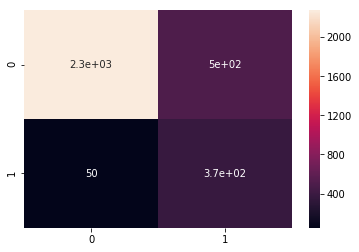

In [72]:
sns.heatmap(cf, annot=True)